In [ ]:
!nvidia-smi

Wed Nov 16 05:57:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     |████████████████████████████████| 5.5 MB 32.1 MB/s 
     |████████████████████████████████| 441 kB 61.1 MB/s 
     |████████████████████████████████| 118 kB 75.3 MB/s 
     |████████████████████████████████| 65 kB 4.9 MB/s 
     |████████████████████████████████| 95 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 77.1 MB/s 
     |████████████████████████████████| 163 kB 77.1 MB/s 
     |████████████████████████████████| 212 kB 79.6 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
     |████████████████████████████████| 93 kB 2.6 MB/s 
     |████████████████████████████████| 138 kB 73.8 MB/s 
     |████████████████████████████████| 379 kB 77.6 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 357 kB 64.1 MB/s 
     |████████████████████████████████| 2.3 MB 53.4 MB/s 
     |████████████████████████████████| 115 kB 73.2 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 
     |████████████████

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import Dataset, load_metric, DatasetDict

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#importing the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/PBL Final/test.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  11490 non-null  object
dtypes: object(3)
memory usage: 269.4+ KB


In [ ]:
print("Number of rows in the data:",data.shape[0])

Number of rows in the data: 11490


In [ ]:
#checking the data for missing values
data.isna().sum()

id            0
article       0
highlights    0
dtype: int64

In [ ]:
import re
#function to remove numbers and punctuations in the data
#removing numbers and punctuations to get exact number of words in the data
def clean_text(text):
  text = text.lower()
  text = re.sub(pattern=r"[^a-zA-Z0-9_\s]",repl="",string=text)
  text = re.sub(pattern=r" {2,10}",repl=" ",string=text)
  return text

In [ ]:
cleaned_data=pd.DataFrame()
cleaned_data['article'] = data['article'].apply(clean_text)
cleaned_data['highlights'] = data['highlights'].apply(clean_text)

summary_lengths=[len(summary.split()) for summary in cleaned_data['highlights']]
text_lengths=[len(text.split()) for text in cleaned_data['article']]

Text(0.5, 0.98, 'Distribution of words in summary and original text')

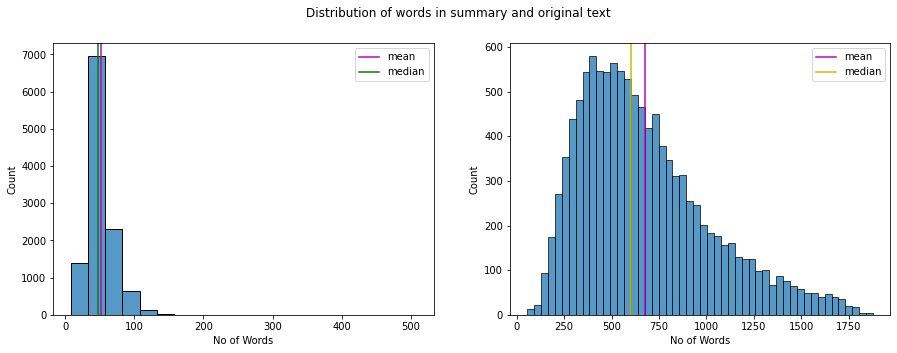

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(summary_lengths,bins=20)
plt.axvline(np.mean(summary_lengths),color="m",label="mean")
plt.axvline(np.median(summary_lengths),color="g",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.subplot(1,2,2)
sns.histplot(text_lengths,bins=50)
plt.axvline(np.mean(text_lengths),color="m",label="mean")
plt.axvline(np.median(text_lengths),color="y",label="median")
plt.legend()
plt.xlabel("No of Words")
plt.suptitle("Distribution of words in summary and original text")

In [ ]:
print("Average number of words in the summary are:",np.median(summary_lengths))
print("Average number of words in the complete text are:",np.median(text_lengths))

Average number of words in the summary are: 48.0
Average number of words in the complete text are: 605.0


In [ ]:
#adding summarize: as prefix for the input sequence
#because the T5 model has been pretrained in the similar fashion for summarization tasks
data['article']=data['article'].apply(lambda x:"summarize: "+x)
data.head(5)

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,summarize: Ever noticed how plane seats appear...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,summarize: A drunk teenage boy had to be rescu...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,summarize: Dougie Freedman is on the verge of ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,summarize: Liverpool target Neto is also wante...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,summarize: Bruce Jenner will break his silence...,"Tell-all interview with the reality TV star, 6..."


In [ ]:
#splitting the data into train and validation split in the ratio (85:15)
split = int(len(data)/100*85)
training_data = data[:split]
valid_data = data[split:]

#saving the training and validation split into CSV
training_data.to_csv("news_summarization_training.csv")
valid_data.to_csv("news_summarization_validation.csv")

In [ ]:
#importing the dataset into huggingface dataset format for efficient handling and training
train_data = pd.read_csv("news_summarization_training.csv",index_col=None)
valid_data = pd.read_csv("news_summarization_validation.csv",index_col=None)
train = Dataset.from_pandas(train_data[0:200])
valid = Dataset.from_pandas(valid_data[0:50])
dataset=DatasetDict()
dataset['training']=train.remove_columns(['Unnamed: 0'])
dataset['validation']=valid.remove_columns(['Unnamed: 0'])
dataset

DatasetDict({
    training: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 50
    })
})

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset['validation'][0]['article'] )

print(pipe_out)

[{'summary_text': 'Memories Gourmet Pizza Co. is in Nichols, Wisconsin .<n>People mistake it for Memories Pizza of Walkerton, Indiana .<n>"My stomach was in my throat all afternoon," says co-owner Kathy Danke .'}]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL"]

rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset['validation'], rouge_metric, model_pegasus, tokenizer, column_text = 'article', column_summary='highlights',batch_size=8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


100%|██████████| 7/7 [01:21<00:00, 11.70s/it]


In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL
pegasus,0.01541,0.001566,0.015585


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['article'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['highlights'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_pt = dataset.map(convert_examples_to_features, batched = True)

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:


from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus', num_train_epochs=20, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 



In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_pt["training"], 
                  eval_dataset=dataset_pt["validation"])

In [ ]:
trainer.train()

score = calculate_metric_on_test_ds(
    dataset['training'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'article', column_summary= 'highlights'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'] )



The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: article, id, highlights. If article, id, highlights are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 200
  Num Epochs = 20
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 240
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 100/100 [05:43<00:00,  3.43s/it]


,rouge1,rouge2,rougeL
pegasus,0.013042,0.000968,0.012854
